In [34]:
import polars as pl
import pyarrow.dataset as ds
from pyarrow import fs
import pandas as pd
from datetime import date, timedelta

from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.metrics import mse
from darts.models import TCNModel, CatBoostModel, NBEATSModel, NLinearModel, RNNModel, ARIMA, TFTModel, RandomForest

from pytorch_lightning.callbacks import Callback
import torch

from pytorch_lightning.callbacks import Callback, EarlyStopping
from optuna.integration import PyTorchLightningPruningCallback
import optuna

import json

# Links

In [2]:
aquatic_link = "https://data.ecoforecast.org/neon4cast-targets/aquatics/aquatics-expanded-observations.csv.gz"
terrestrial_link = "https://data.ecoforecast.org/neon4cast-targets/terrestrial_30min/terrestrial_30min-targets.csv.gz"
tick_link = "https://data.ecoforecast.org/neon4cast-targets/ticks/ticks-targets.csv.gz"
phenology_link = "https://data.ecoforecast.org/neon4cast-targets/phenology/phenology-targets.csv.gz"
beetle_link = "https://data.ecoforecast.org/neon4cast-targets/beetles/beetles-targets.csv.gz"

# Data-processing utility functions

In [9]:
def NOAA_stage3_scan(
    site_id:str = "TREE", 
    variable:str = "TMP"
):
    s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)
    path = "neon4cast-drivers/noaa/gefs-v12/stage3/parquet"
    dataset = ds.dataset(path, filesystem=s3)
    return (
        pl.scan_pyarrow_dataset(dataset)
        .filter(pl.col("site_id") == site_id)
        .filter(
          (pl.col("variable") == variable)
        )
        .collect()
        # .pivot(index = "datetime", columns = "variable", values = "prediction")
    )

def get_noaa(
    site_id = "KONZ",
    day_avg = True,
    freq = "D"
):
    s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)
    path = f"neon4cast-drivers/noaa/gefs-v12/stage3/parquet/"
    dataset = ds.dataset(path, filesystem=s3, partitioning=["site_id"])

    historic_noaa_full = pl.scan_pyarrow_dataset(dataset) 

    # specialize to a given site, go to pivot
    historic_noaa = (
        historic_noaa_full
        .filter(pl.col("site_id") == site_id)
        .collect()
        .pivot(index = "datetime", columns = "variable", values = "prediction")
    )
    # historic_noaa["datetime"] = pd.to_datetime(historic_noaa["datetime"])
    # historic_noaa.with_columns(pl.col("datetime").cast(pl.Datetime).alias("datetime"))

    # thin out
    historic_noaa = historic_noaa[["datetime", "air_temperature", "air_pressure", "precipitation_flux", "relative_humidity"]]

    # optionally day-average:
    if day_avg:
        freq = "D" # override input as safety because only "D" makes sense here
        historic_noaa_daily = day_mean_several(
            historic_noaa, 
            ["air_temperature", "air_pressure", "precipitation_flux", "relative_humidity"]
        )
        historic_noaa_daily.columns = ["date", "tmp_avg", "pressure_avg", "precip_flux_avg", "rel_humidity_avg"]
        return fill_missing_values( 
            pl_to_series(
                historic_noaa_daily, time_col = "date", freq = freq
            )
        )
    
    return fill_missing_values(
        pl_to_series(
            historic_noaa, time_col = "datetime", freq = freq
        )
    )

def day_mean(df, var_to_avg = "TMP", time_col = "datetime", avg_name = "TMP_day_avg"):
    """
    averages values of the column given over the course of a day
    """
    return (
        df
        .with_columns(pl.col(time_col).cast(pl.Date).alias("date"))
        .groupby("date")
        .agg(
            [
                pl.col(var_to_avg).mean().alias(avg_name)
            ]
        )
        .sort("date")
    )

def day_mean_several(df, var_names, time_col = "datetime", avg_name_app = "day_avg"):
    """
    averages values of the column given over the course of a day
    """
    return (
        df
        .with_columns(pl.col(time_col).cast(pl.Date).alias("date"))
        .groupby("date")
        .agg(
            [
                pl.col(var).mean().alias("_".join([var,avg_name_app])) for var in var_names
            ]
        )
        .sort("date")
    )

def pl_to_series(df, time_col = "date", freq = "D"):
    """
    input: polars dataframe
    output: corresponding darts.TimeSeries
    
    for now the easiest thing is to use pandas as a middle-man.
    """
    pd_df = df.to_pandas()
    pd_df[time_col] = pd.to_datetime(pd_df[time_col]).dt.tz_localize(None)
    return (
        TimeSeries.from_dataframe(
            pd_df,
            time_col = time_col,
            freq = freq,
        )
    )

def read_neon(
    site_id, 
    time_col = "datetime", 
    link = "https://data.ecoforecast.org/neon4cast-targets/beetles/beetles-targets.csv.gz",
):
    site_data = pd.read_csv(link)
    site_data[time_col] = pd.to_datetime(site_data["datetime"]).dt.tz_localize(None)
    return (
        site_data
        .loc[site_data["site_id"] == site_id]
    )


def inspect_variables(
    link,
    var_col_names = ["variable"],
):
    site_data = pd.read_csv(link)
    print(f"inspect_variables: FYI, the columns are {site_data.columns}")
    return (
        {
            var: f"{site_data[var].unique()}".replace("\n","") for var in var_col_names
        }
    )

In [4]:
def quick_neon_series(
    site_id,
    link = terrestrial_link,
    freq = "D",
    time_col = "datetime",
    day_avg: bool = False,
    start_date = pd.Timestamp("2020-09-25"),
):
    # pandas
    data = read_neon(
        site_id = site_id, 
        time_col = time_col, 
        link = link,
    )
    
    # polars
    data_pl = pl.from_pandas(
        data
        .pivot(index = time_col, columns = "variable", values = "observation")
        .reset_index()
    )
    
    # optional average
    if day_avg:
        freq = "D" # override user-set frequency
        data_pl = day_mean_several(
            data_pl, 
            data["variable"].unique(), 
            time_col = time_col, 
            avg_name_app = "day_avg",
        )
        time_col = "date"
    
    # darts
    data_series = fill_missing_values(
        pl_to_series(data_pl, time_col = time_col, freq = freq)
    )
    
    # split
    pre, data_series_out = data_series.split_before(start_date)
    
    return data_series_out

# Globals


In [325]:
SITE = "OAES"
COVARIATE_SITES = ["CLBJ", "DELA", "JORN"] # ["KONZ", "KONA"] ## just for memory

# Get NEON

In [326]:
neon_series = quick_neon_series(
    site_id = SITE,
    link = terrestrial_link,
    freq = "D",
    time_col = "datetime",
    day_avg= True,
)

neon_covariate_list = [
    quick_neon_series(
        site_id = site,
        link = terrestrial_link,
        freq = "D",
        time_col = "datetime",
        day_avg= True,
    )
    for site in COVARIATE_SITES
]

In [327]:
# neon_covariate_list

# Get NOAA

In [328]:
noaa_covariates = get_noaa(site_id = SITE)

In [329]:
# noaa_covariates.columns

In [330]:
# noaa_covariates['rel_humidity_avg'].plot()

# Cut-n-box

#### Cut

In [331]:
date_cutoff = pd.Timestamp("2023-02-20")

# NEON MAIN SERIES
neon_train, neon_val = neon_series.split_before(date_cutoff)

# NOAA COV
past_noaa, future_noaa = noaa_covariates.split_before(date_cutoff)

# NEON COV
if len(neon_covariate_list) > 0:
    past_future_neon_covariates = list(
        zip(*[neon_covariate.split_before(date_cutoff) for neon_covariate in neon_covariate_list])
    )
    past_neon_covariate_list = list(past_future_neon_covariates[0])
    future_neon_covariate_list = list(past_future_neon_covariates[1])
else:
    past_neon_covariate_list = []

In [332]:
# past_neon_covariate_list

In [333]:
# # example for how NEON COV works:

# a = list(zip(*[("a", "b"), ("c", "d"), ("e", "f")]))
# list(a[0])

#### Box

In [334]:
covariates = past_noaa
for cov in past_neon_covariate_list:
    covariates = covariates.concatenate(cov, axis = "component")

In [335]:
# covariates.columns

# Fit

In [336]:
rf = RandomForest(
    output_chunk_length = 32,
    lags=78,
    lags_past_covariates=64,
    n_estimators=116,
    max_depth=9,
)

In [337]:
rf.fit(
    series = neon_train,
    past_covariates = covariates,
)

In [338]:
forecast = rf.predict(len(neon_val))

# Plot

In [339]:
neon_pre, neon_plt = neon_series.split_before(pd.Timestamp("2022-10-01"))


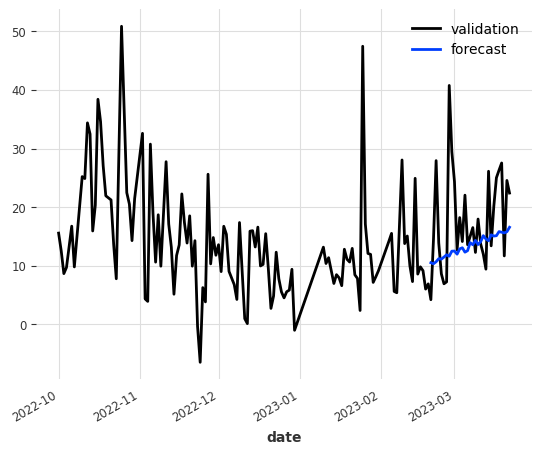

In [342]:
neon_plt['le_day_avg'].plot(label = "validation")
# neon_val['le_day_avg'].plot(label = "validation")
# neon_series['le_day_avg'].plot(label = "validation")
forecast['le_day_avg'].plot(label = "forecast")

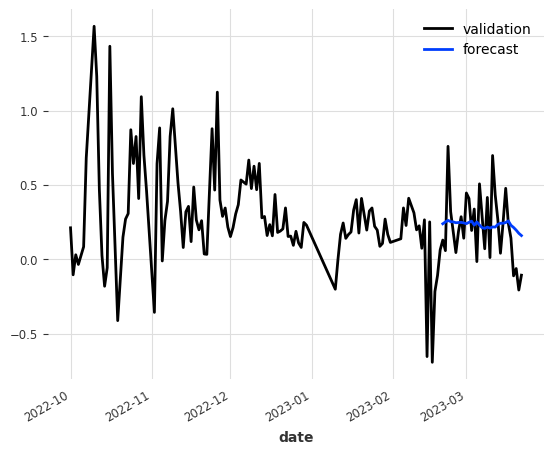

In [341]:
neon_plt['nee_day_avg'].plot(label = "validation")
# neon_val['nee_day_avg'].plot(label = "validation")
forecast['nee_day_avg'].plot(label = "forecast")

# Notes:

- MLBS has an outlier that screws up the predictions. Data pre-processing to detect and remove outliers might be useful in sites like this one.  
- OSBS, TALL missing quite a bit of data close to spring. Some sites may have missing data around the dates we want to do predictions. What is better: to include neighbors as covariates to "add" more predictors in for the missing data, or to stack them all as a single timeseries with multiple variables?